# Load software

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Math
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from collections import defaultdict
import lmfit
from ipywidgets import interact

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.sans-serif'].insert(0, 'Arial')
plt.rcParams['path.simplify_threshold'] = 1.0
plt.rcParams['font.size'] = 14

pd.options.display.max_columns = 48
pd.options.display.max_rows = 48

In [3]:
from fretbursts import *

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/fretbursts/__init__.py:63: UserWarning:  - Cannot import QT, custom GUI widgets disabled.
  warnings.warn((' - Cannot import QT, custom GUI widgets disabled.'))


 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [4]:
sns = init_notebook(apionly=True)

In [5]:
plot_timetraces = True

# Define input data files

In [6]:
dir_ = './results'

In [7]:
ls $dir_

05_-8TA_-3NTD_500pM_0-80s_burst_data.csv
06_-8TA_-3NTD_500pM_ASchip_0-80s_burst_data.csv


# Load  burst data

As a first step we create a list of each CSV file

In [8]:
# sort to have chronological order for measurements
filepaths = sorted([f for f in Path(dir_).glob('*.csv')
                   if 'burst_data' in f.stem]) 
fnames = [f.name for f in filepaths]
fnames

['05_-8TA_-3NTD_500pM_0-80s_burst_data.csv',
 '06_-8TA_-3NTD_500pM_ASchip_0-80s_burst_data.csv']

In [9]:
f0path = f'{dir_}/{fnames[0]}'
f1path = f'{dir_}/{fnames[1]}'

In [10]:
sample_description0 = 'no_flow_control'
df0 = pd.read_csv(f0path, index_col=0).assign(sample_description=sample_description0)
df0.head()

,size_raw,t_start,t_stop,width_ms,E,S,nd,na,nt,nda,naa,max_rate,nar,spot,sample_description
0,10,0.111762,0.111955,0.192625,-0.109697,0.378698,0.566183,-0.251053,8.331979,4.513142,3.503707,32956.463262,-0.251053,0,no_flow_control
1,33,0.220837,0.221162,0.325062,0.163064,1.098282,15.267917,2.576337,30.185147,11.178408,1.162485,174177.702928,2.576337,0,no_flow_control
2,13,0.231640,0.231863,0.222663,-0.051113,1.052553,9.498535,-0.290202,11.071872,2.437223,-0.573684,58489.854491,-0.290202,0,no_flow_control
3,13,0.231704,0.231950,0.246125,-0.069871,0.731326,7.445694,-0.320781,10.868700,2.377922,1.365865,45575.087493,-0.320781,0,no_flow_control
4,11,0.235145,0.235333,0.187812,0.365185,1.052354,3.577022,1.755219,9.373653,2.525306,1.516106,39125.668436,1.755219,0,no_flow_control


In [11]:
sample_description1 = 'AS_chip_with_flow'
df1 = pd.read_csv(f1path, index_col=0).assign(sample_description=sample_description1)
df1.head()

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,size_raw,t_start,t_stop,width_ms,E,S,nd,na,nt,nda,naa,max_rate,nar,spot,sample_description
0,13,0.107419,0.107582,0.162663,0.129792,1.033822,5.239882,0.697730,10.575663,4.116193,0.521858,52532.416089,0.697730,0,AS_chip_with_flow
1,21,0.107743,0.108094,0.351037,0.309973,0.924282,4.359610,2.347679,15.768104,6.092681,2.968135,52688.558840,2.347679,0,AS_chip_with_flow
2,10,0.107972,0.108166,0.194075,0.394203,1.410277,2.093092,1.639357,7.107488,2.945517,0.429522,26434.775756,1.639357,0,AS_chip_with_flow
3,51,0.108023,0.108628,0.605100,0.126022,1.190686,22.172382,2.875563,41.981533,17.712263,-0.778675,213377.591246,2.875563,0,AS_chip_with_flow
4,10,0.110811,0.110991,0.180475,0.177109,1.054850,1.156645,0.664629,7.310184,5.019411,0.469499,29541.067555,0.664629,0,AS_chip_with_flow


In [12]:
dataframe_list = [df0, df1]

bursts_all = pd.concat(dataframe_list, ignore_index=True)
#bursts_all['max_rate'] *= 1e-3
bursts_all.sample(10).sort_values(['sample_description'])

,size_raw,t_start,t_stop,width_ms,E,S,nd,na,nt,nda,naa,max_rate,nar,spot,sample_description
1577433,14,71.942198,71.942521,0.323000,0.480420,1.531985,1.474660,1.275704,4.388695,1.284717,0.353614,27815.070547,1.275704,30,AS_chip_with_flow
1674578,10,59.952957,59.953149,0.192600,0.648569,0.740248,1.120018,1.168587,4.235834,0.146396,1.800834,11649.765499,1.168587,32,AS_chip_with_flow
1778899,11,60.343404,60.343600,0.195837,-0.315280,0.301292,1.124869,-0.411985,5.643808,2.312553,2.618370,13493.377859,-0.411985,33,AS_chip_with_flow
1382948,13,15.146049,15.146263,0.213325,0.306869,5.255559,4.453502,1.522274,5.904559,2.423288,-2.494505,25177.561447,1.522274,29,AS_chip_with_flow
1282912,11,8.951294,8.951498,0.204538,-0.266346,0.475076,0.905698,-0.466293,5.435798,3.528291,1.468102,12760.225097,-0.466293,28,AS_chip_with_flow
407827,12,59.311149,59.311339,0.190087,0.654706,0.785392,0.116989,1.571763,5.457424,1.540917,2.227756,16729.836493,1.571763,6,AS_chip_with_flow
1051392,27,35.614002,35.614399,0.397112,0.768524,1.096690,4.135767,6.099455,15.173437,-0.461511,5.399725,149362.586762,6.099455,18,AS_chip_with_flow
1150562,14,6.878819,6.879074,0.254862,0.159449,0.445415,1.852496,0.378169,7.696461,2.134604,3.331192,30455.452275,0.378169,21,AS_chip_with_flow
2359196,10,11.069957,11.070137,0.180625,0.522912,1.253798,1.240119,1.663121,5.717195,1.794641,1.019313,18532.283787,1.663121,47,AS_chip_with_flow
82868,12,37.217123,37.217362,0.239150,0.675138,0.703441,0.354131,2.646471,9.492355,2.192719,4.299034,63980.620311,2.646471,28,no_flow_control


In [13]:
bursts_all.groupby(['spot', 'sample_description']).head()

,size_raw,t_start,t_stop,width_ms,E,S,nd,na,nt,nda,naa,max_rate,nar,spot,sample_description
0,10,0.111762,0.111955,0.192625,-0.109697,0.378698,0.566183,-0.251053,8.331979,4.513142,3.503707,32956.463262,-0.251053,0,no_flow_control
1,33,0.220837,0.221162,0.325062,0.163064,1.098282,15.267917,2.576337,30.185147,11.178408,1.162485,174177.702928,2.576337,0,no_flow_control
2,13,0.231640,0.231863,0.222663,-0.051113,1.052553,9.498535,-0.290202,11.071872,2.437223,-0.573684,58489.854491,-0.290202,0,no_flow_control
3,13,0.231704,0.231950,0.246125,-0.069871,0.731326,7.445694,-0.320781,10.868700,2.377922,1.365865,45575.087493,-0.320781,0,no_flow_control
4,11,0.235145,0.235333,0.187812,0.365185,1.052354,3.577022,1.755219,9.373653,2.525306,1.516106,39125.668436,1.755219,0,no_flow_control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2352777,11,0.091730,0.091935,0.204637,0.250167,0.658046,0.133296,0.613178,6.175856,3.542498,1.886883,19665.416767,0.613178,47,AS_chip_with_flow
2352778,16,0.093393,0.093680,0.286612,-0.149237,0.646760,-0.213894,-0.541777,9.243369,8.558057,1.440983,29394.832138,-0.541777,47,AS_chip_with_flow
2352779,11,0.096079,0.096319,0.240075,0.498232,0.258296,0.983207,0.546192,5.340449,0.116928,3.694122,17799.443010,0.546192,47,AS_chip_with_flow
2352780,10,0.098762,0.098948,0.186438,-0.133831,0.886156,1.210379,-0.352419,5.604904,4.761063,-0.014119,17056.035680,-0.352419,47,AS_chip_with_flow


# Burst size distribution

In [14]:
num_bursts0 = len(df0)
num_bursts1 = len(df1)
print(f'Number of bursts without flow = {num_bursts0}')
print(f'Number of bursts Streets chip and flow = {num_bursts1}')

Number of bursts without flow = 151984
Number of bursts Streets chip and flow = 2246944


In [15]:
print(f'The number of bursts increases by {np.int(num_bursts1 / num_bursts0)}x when flow is applied '
      '(before burst search and burst selection)')

The number of bursts increases by 14x when flow is applied (before burst search and burst selection)


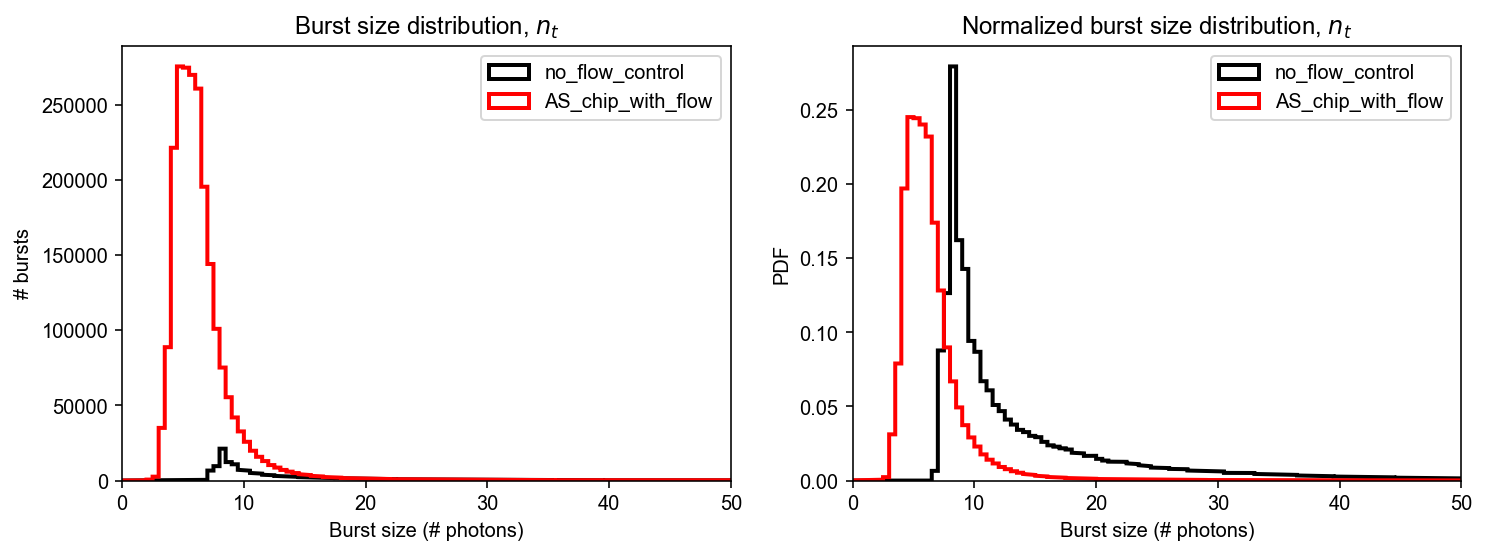

In [16]:
th1 = 20
column = 'nt'
binwidth = 0.5
hist_kws = dict(histtype='step', lw=2)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
size0 = bursts_all.loc[bursts_all.sample_description == sample_description0, column]
size1 = bursts_all.loc[bursts_all.sample_description == sample_description1, column]
bins = np.arange(-1, size0.max(), binwidth)
#bin1 = np.arange(-1, size1.max(), binwidth)

ax[0].hist(size0, label='no_flow_control', color='k', bins=bins, **hist_kws)
ax[0].hist(size1, label='AS_chip_with_flow', color='r', bins=bins, **hist_kws)
#ax[0].set_yscale('log')
#ax[0].axvline(th1, color='k', ls='--')
ax[0].legend(loc='upper right')
ax[0].set_ylabel('# bursts')
ax[0].set_xlabel('Burst size (# photons)')
ax[0].set_title('Burst size distribution, $n_t$');
ax[0].set_xlim(-10, 50)

th2 = 20
column = 'nt'
size2 = bursts_all.loc[bursts_all.sample_description == sample_description0, column]
size3 = bursts_all.loc[bursts_all.sample_description == sample_description1, column]
bins = np.arange(-1, size2.max(), binwidth)
#bin1 = np.arange(-1, size3.max(), binwidth)

ax[1].hist(size2, density=True, stacked=True, label='no_flow_control', color='k', bins=bins, **hist_kws)
ax[1].hist(size3, density=True, stacked=True, label='AS_chip_with_flow', color='r', bins=bins, **hist_kws)
#ax[1].set_yscale('log')
#ax[1].axvline(th2, color='k', ls='--')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('PDF')
ax[1].set_xlabel('Burst size (# photons)')
ax[1].set_title('Normalized burst size distribution, $n_{t}$');
ax[1].set_xlim(0, 50)
plt.savefig('burst_size_distribution_vs_PDF.png', dpi=1200)

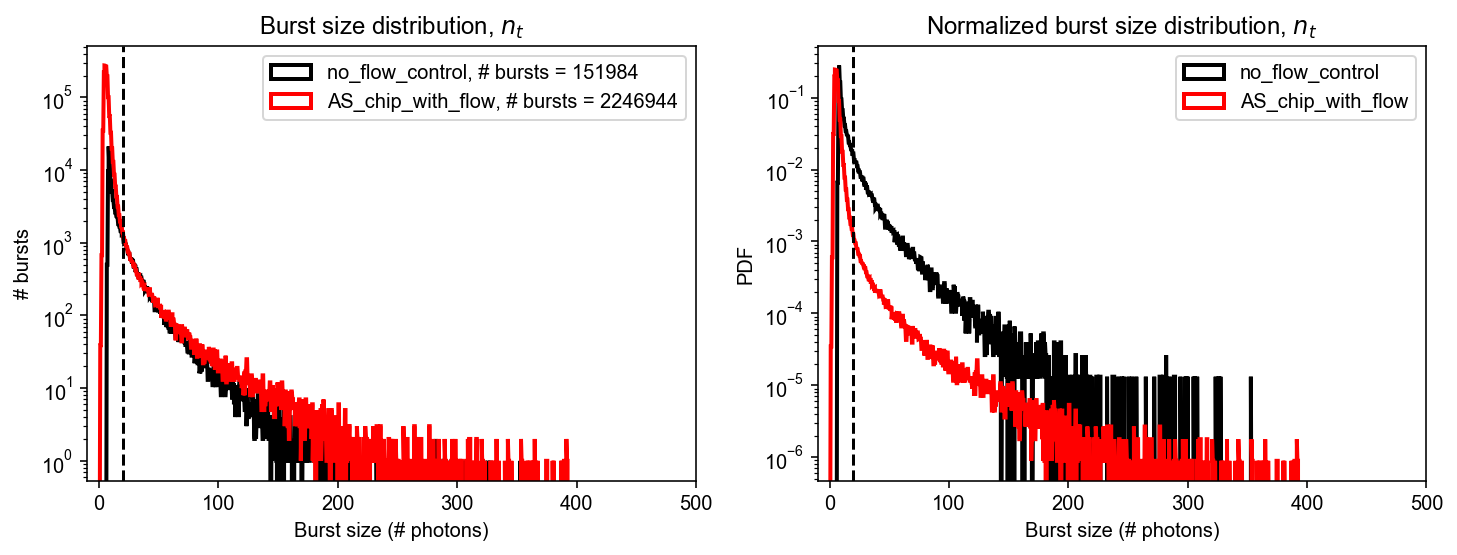

In [17]:
th1 = 20
column = 'nt'
binwidth = 0.5
hist_kws = dict(histtype='step', lw=2)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
size0 = bursts_all.loc[bursts_all.sample_description == sample_description0, column]
size1 = bursts_all.loc[bursts_all.sample_description == sample_description1, column]
bins = np.arange(-1, size0.max(), binwidth)
#bin1 = np.arange(-1, size1.max(), binwidth)

ax[0].hist(size0, label=f'{sample_description0}, # bursts = {num_bursts0}', color='k', bins=bins, **hist_kws)
ax[0].hist(size1, label=f'{sample_description1}, # bursts = {num_bursts1}', color='r', bins=bins, **hist_kws)
ax[0].set_yscale('log')
ax[0].axvline(th1, color='k', ls='--')
ax[0].legend(loc='upper right')
ax[0].set_ylabel('# bursts')
ax[0].set_xlabel('Burst size (# photons)')
ax[0].set_title('Burst size distribution, $n_t$');
ax[0].set_xlim(-10, 500)

th2 = 20
column = 'nt'
size2 = bursts_all.loc[bursts_all.sample_description == sample_description0, column]
size3 = bursts_all.loc[bursts_all.sample_description == sample_description1, column]
bins = np.arange(-1, size2.max(), binwidth)
#bin1 = np.arange(-1, size3.max(), binwidth)

ax[1].hist(size2, density=True, stacked=True, label='no_flow_control', 
           color='k', bins=bins, range=(0,500), **hist_kws)
ax[1].hist(size3, density=True, stacked=True, label='AS_chip_with_flow', 
           color='r', bins=bins, range=(0,500), **hist_kws)
ax[1].set_yscale('log')
ax[1].axvline(th2, color='k', ls='--')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('PDF')
ax[1].set_xlabel('Burst size (# photons)')
ax[1].set_title('Normalized burst size distribution, $n_{t}$');
ax[1].set_xlim(-10, 500)

plt.savefig('burst_size_distribution_vs_PDF_semilog.png', dpi=1200)

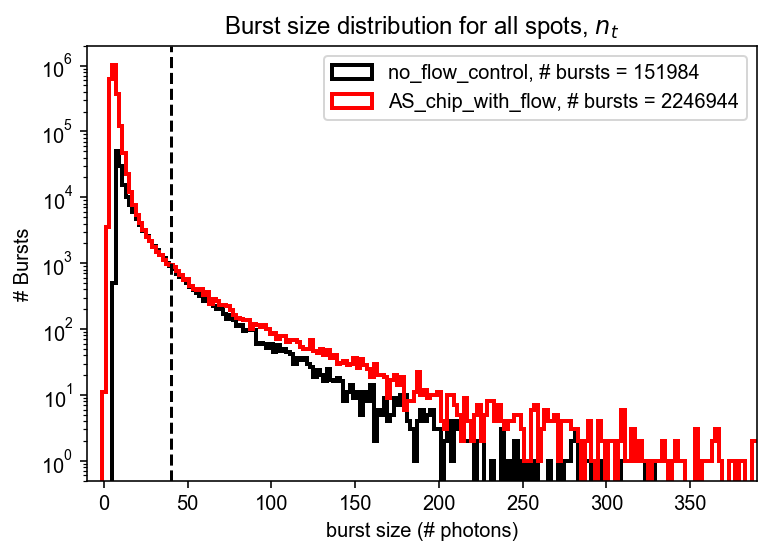

In [18]:
th = 40
column = 'nt'
binwidth = 2
hist_kws = dict(histtype='step', lw=2)

plt.figure()
size0 = bursts_all.loc[bursts_all.sample_description == sample_description0, column] 
size1 = bursts_all.loc[bursts_all.sample_description == sample_description1, column] 
bin0 = np.arange(-1, size0.max(), binwidth)
bin1 = np.arange(-1, size1.max(), binwidth)

plt.hist(size0, label=f'{sample_description0}, # bursts = {num_bursts0}', 
         color='k', bins=bin0, **hist_kws)
plt.hist(size1, label=f'{sample_description1}, # bursts = {num_bursts1}', 
         color='r', bins=bin1, **hist_kws)
plt.xlim(-10, size0.quantile(0.99999) + 50)
plt.axvline(th, color='k', ls='--')
plt.legend(loc='upper right')
plt.yscale('log')
plt.ylabel('# Bursts')
plt.xlabel('burst size (# photons)')
plt.title(f'Burst size distribution for all spots, $n_t$');
plt.savefig('burst_size_distribution_nt.png', dpi=1200)

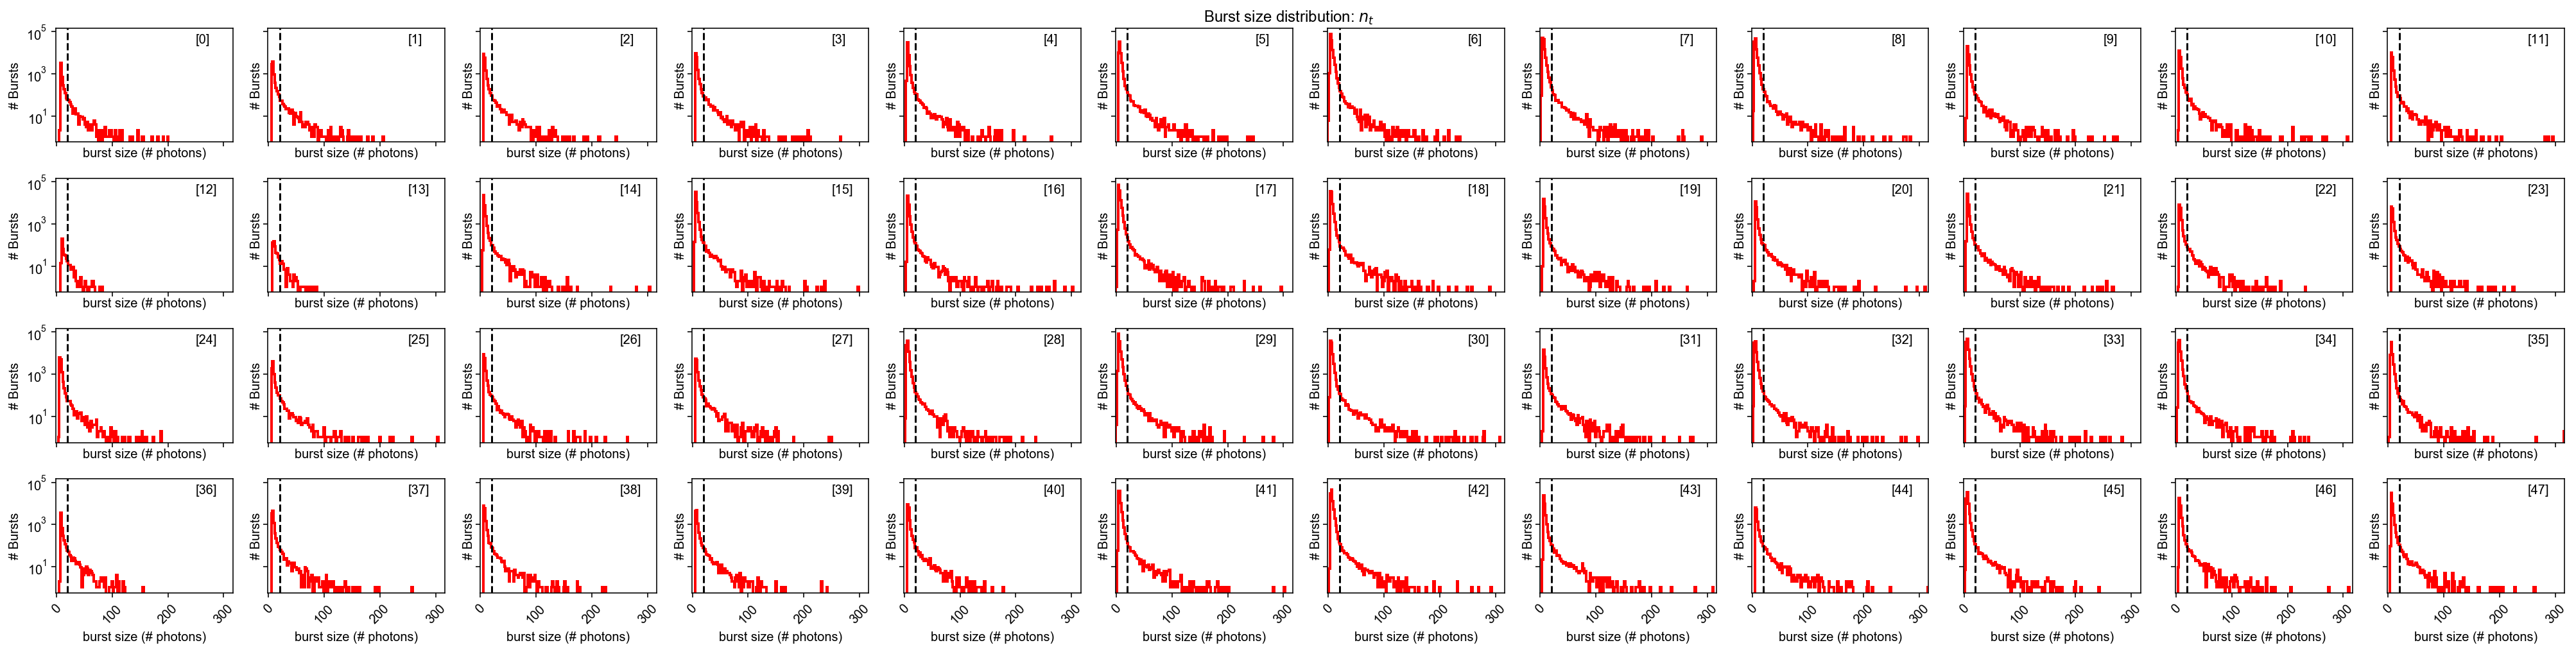

In [19]:
nrows = 4
ncols = 12
figsize = (1.5 * ncols + 10, 1.5 * nrows + 1)
hist_kws = dict(histtype='step', lw=2)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=figsize)
axes_list = [item for sublist in axes for item in sublist] 

th = 20
xrotation = 45
column = 'nt'
for spot, group in bursts_all.groupby('spot'):
    ax = axes_list[spot]
    size1 = group.loc[group.sample_description == sample_description1, column]
    bins = np.arange(-1, size1.max(), 2)
    ax.hist(size1, bins, color='r', **hist_kws)
    ax.set_yscale('log')
    ax.axvline(th, color='k', ls='--')
    ax.set_xlim(-1, size1.quantile(0.99999) + 1)
    ax.set_xlabel('burst size (# photons)')
    ax.set_ylabel('# Bursts')
    ax.text(250, 3e4, f'[{spot}]')
    #ax.legend(loc='upper right', prop={'size': 8})
    plt.setp(ax.get_xticklabels(), rotation=xrotation)
    #ax.tick_params(axis='both', which='major', left=True)
fig.suptitle(f'Burst size distribution: $n_t$', x=0.5,y=1.0)
#plt.legend(sample_description0, sample_description1)
plt.tight_layout()
plt.savefig('burst_size_distribution_48_spots_nt_flow_only.png', dpi=1200);

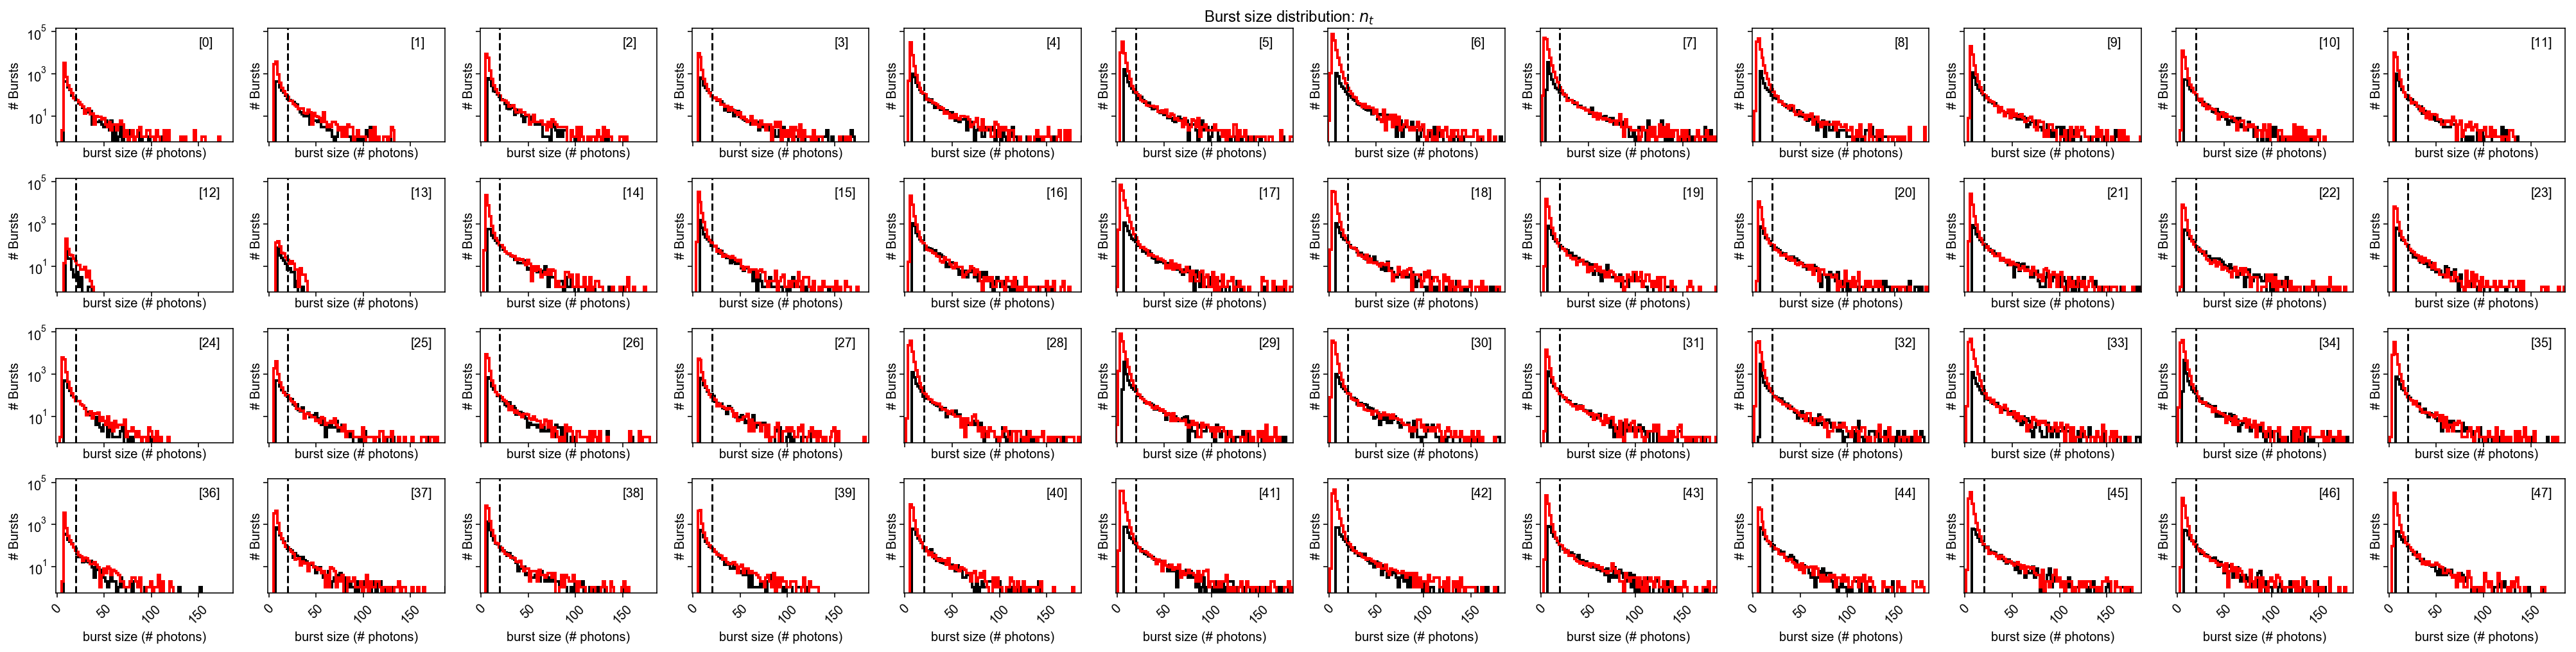

In [20]:
nrows = 4
ncols = 12
figsize = (1.5 * ncols + 10, 1.5 * nrows + 1)
hist_kws = dict(histtype='step', lw=2)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=figsize)
axes_list = [item for sublist in axes for item in sublist] 

th = 20
xrotation = 45
column = 'nt'
for spot, group in bursts_all.groupby('spot'):
    ax = axes_list[spot]
    size0 = group.loc[group.sample_description == sample_description0, column]
    size1 = group.loc[group.sample_description == sample_description1, column]
    bins = np.arange(-1, size0.max(), 2)
    #bins1 = np.arange(-1, size1.max(), 2)
    ax.hist(size0, bins, color='k', **hist_kws)
    ax.hist(size1, bins, color='r', **hist_kws)
    ax.set_yscale('log')
    ax.axvline(th, color='k', ls='--')
    ax.set_xlim(-1, size0.quantile(0.99999) + 10)
    ax.set_xlabel('burst size (# photons)')
    ax.set_ylabel('# Bursts')
    ax.text(150, 2e4, f'[{spot}]')
    #ax.legend(loc='upper right', prop={'size': 8})
    plt.setp(ax.get_xticklabels(), rotation=xrotation)
    #ax.tick_params(axis='both', which='major', left=True)
fig.suptitle(f'Burst size distribution: $n_t$', x=0.5,y=1.0)
#plt.legend(sample_description0, sample_description1)
plt.tight_layout()
plt.savefig('burst_size_distribution_48_spots_nt.png', dpi=1200);

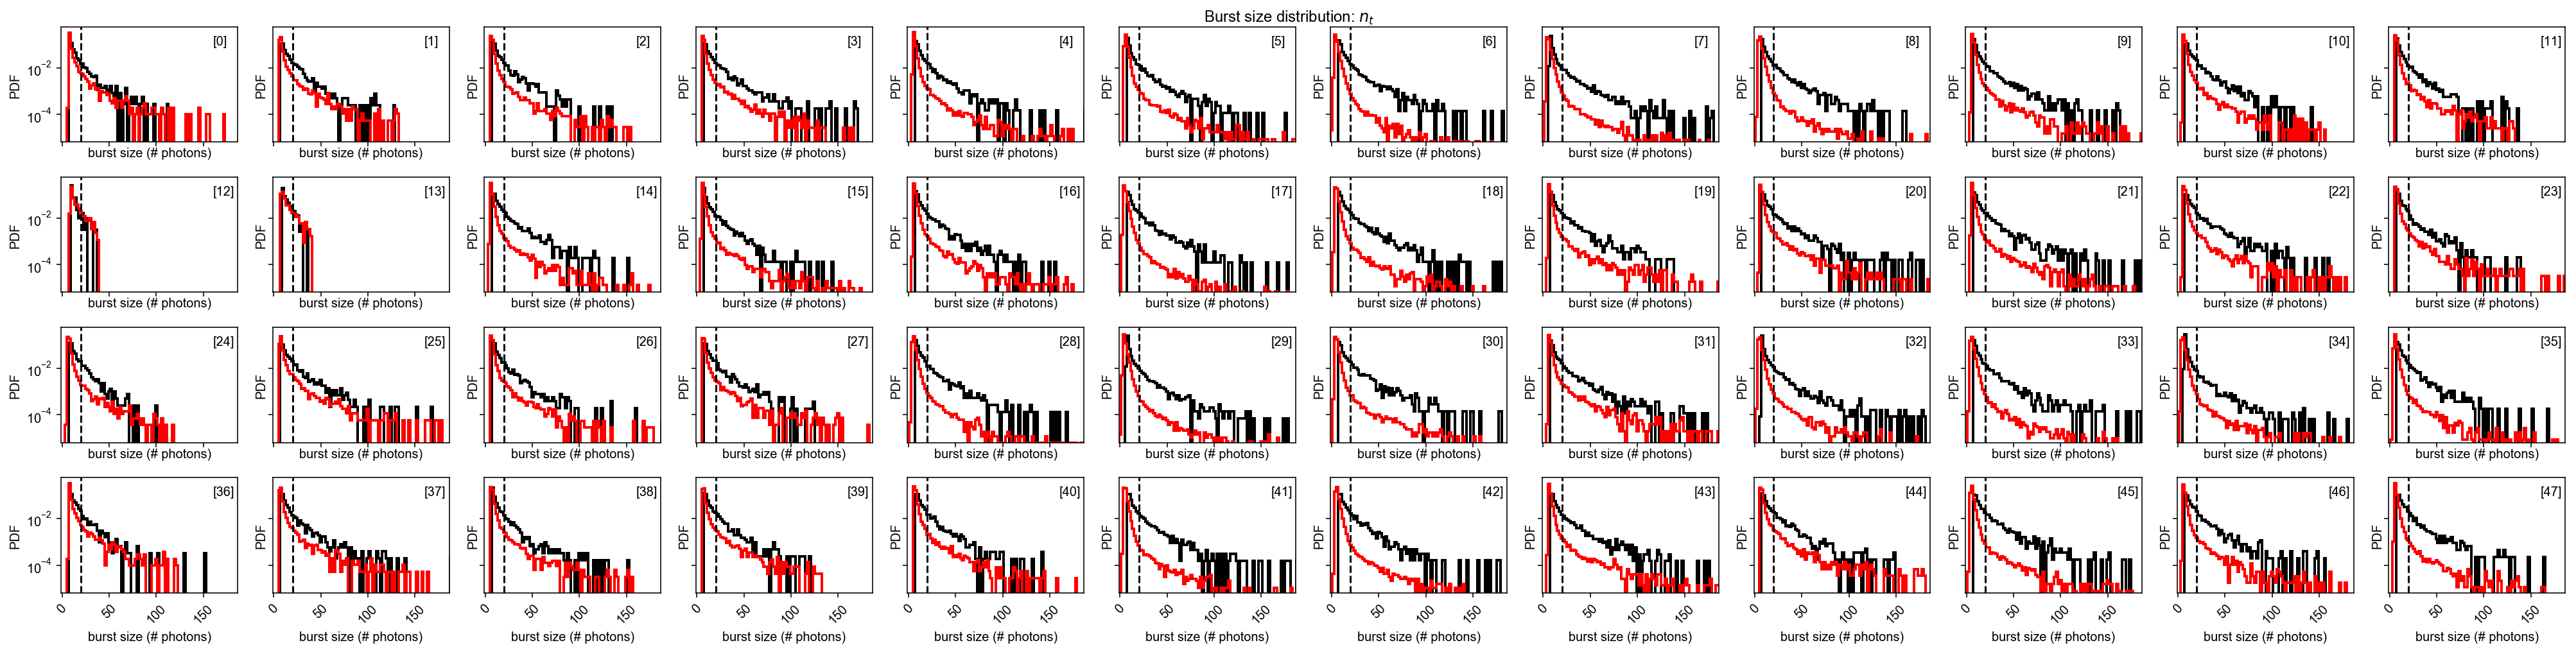

In [21]:
nrows = 4
ncols = 12
figsize = (1.5 * ncols + 10, 1.5 * nrows + 1)
hist_kws = dict(histtype='step', lw=2)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=figsize)
axes_list = [item for sublist in axes for item in sublist] 

th = 20
xrotation = 45
column = 'nt'
for spot, group in bursts_all.groupby('spot'):
    ax = axes_list[spot]
    size0 = group.loc[group.sample_description == sample_description0, column]
    size1 = group.loc[group.sample_description == sample_description1, column]
    bins = np.arange(-1, size0.max(), 2)
    #bins1 = np.arange(-1, size1.max(), 2)
    ax.hist(size0, bins, density=True, stacked=True, color='k', **hist_kws)
    ax.hist(size1, bins, density=True, stacked=True, color='r', **hist_kws)
    ax.set_yscale('log')
    ax.axvline(th, color='k', ls='--')
    ax.set_xlim(-1, size0.quantile(0.99999) + 10)
    ax.set_xlabel('burst size (# photons)')
    ax.set_ylabel('PDF')
    ax.text(160, 10e-2, f'[{spot}]')
    #ax.legend(loc='upper right', prop={'size': 8})
    plt.setp(ax.get_xticklabels(), rotation=xrotation)
    #ax.tick_params(axis='both', which='major', left=True)
fig.suptitle(f'Burst size distribution: $n_t$', x=0.5,y=1.0)
#plt.legend(sample_description0, sample_description1)
plt.tight_layout()
plt.savefig('burst_size_PDF_48_spots_nt.png', dpi=1200);

# Burst duration  distribution

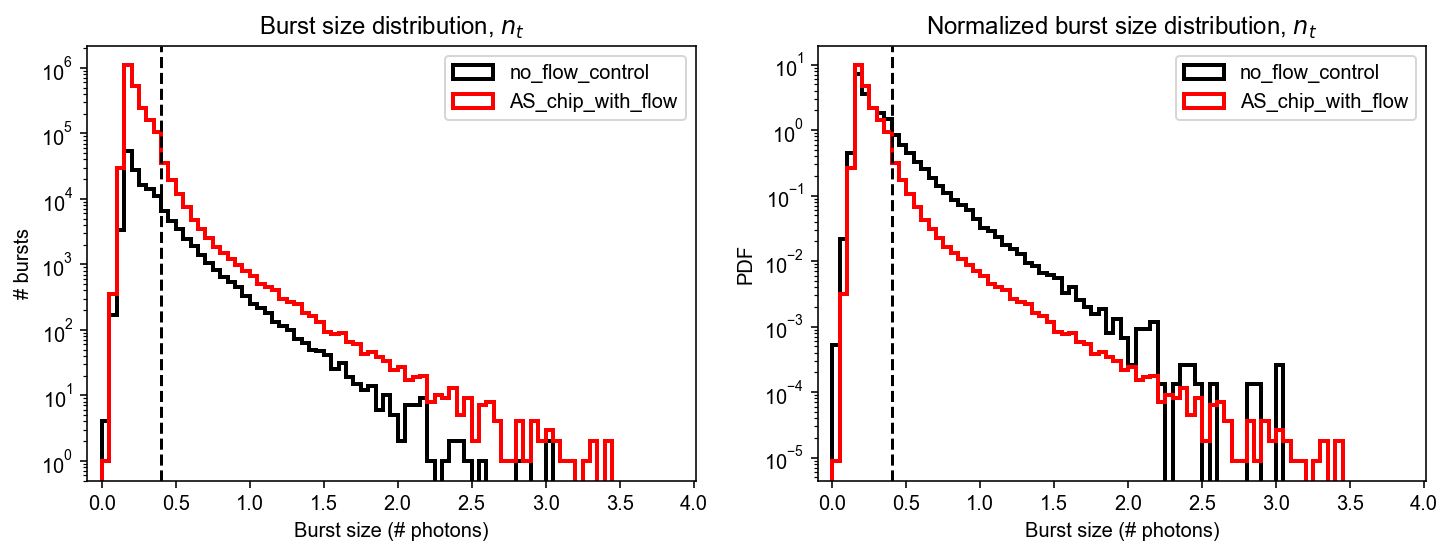

In [22]:
th1 = 0.4
column = 'width_ms'
binwidth = 0.05
hist_kws = dict(histtype='step', lw=2)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
width0 = bursts_all.loc[bursts_all.sample_description == sample_description0, column]
width1 = bursts_all.loc[bursts_all.sample_description == sample_description1, column]
bins = np.arange(-1, width0.max(), binwidth)
#bin1 = np.arange(-1, width1.max(), binwidth)

ax[0].hist(width0, label=f'{sample_description0}', color='k', bins=bins, **hist_kws)
ax[0].hist(width1, label=f'{sample_description1}', color='r', bins=bins, **hist_kws)
ax[0].set_yscale('log')
ax[0].axvline(th1, color='k', ls='--')
ax[0].legend(loc='upper right')
ax[0].set_ylabel('# bursts')
ax[0].set_xlabel('Burst size (# photons)')
ax[0].set_title('Burst size distribution, $n_t$');
ax[0].set_xlim(-.1, width0.quantile(0.99999) + 1)

width2 = bursts_all.loc[bursts_all.sample_description == sample_description0, column]
width3 = bursts_all.loc[bursts_all.sample_description == sample_description1, column]
bins = np.arange(-1, width2.max(), binwidth)
#bin1 = np.arange(-1, width3.max(), binwidth)

ax[1].hist(width2, density=True, stacked=True, label='no_flow_control', 
           color='k', bins=bins, range=(0,500), **hist_kws)
ax[1].hist(width3, density=True, stacked=True, label='AS_chip_with_flow', 
           color='r', bins=bins, range=(0,500), **hist_kws)
ax[1].set_yscale('log')
ax[1].axvline(th1, color='k', ls='--')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('PDF')
ax[1].set_xlabel('Burst size (# photons)')
ax[1].set_title('Normalized burst size distribution, $n_{t}$');
ax[1].set_xlim(-.1, width0.quantile(0.99999) + 1)

plt.savefig('burst_width_distribution_vs_PDF_semilog.png', dpi=1200)

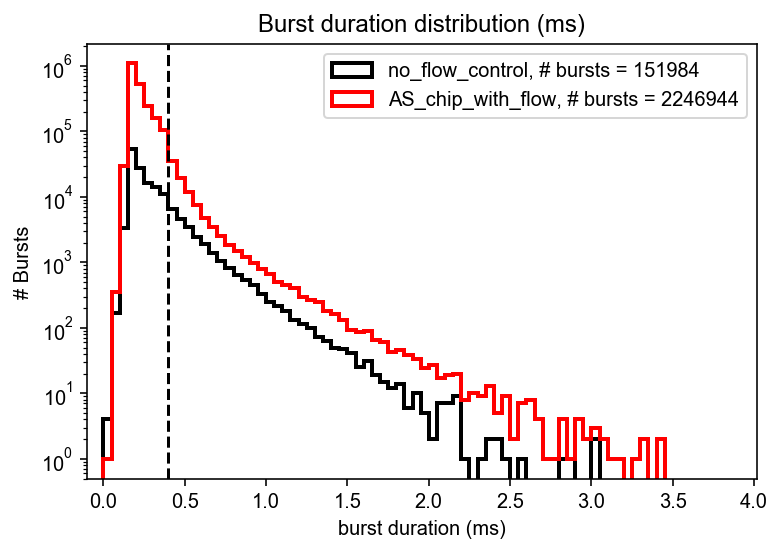

In [23]:
width_th = 0.4
column = 'width_ms'
binwidth = 0.05
hist_kws = dict(histtype='step', lw=2)

plt.figure()
width0 = bursts_all.loc[bursts_all.sample_description == sample_description0, column]
width1 = bursts_all.loc[bursts_all.sample_description == sample_description1, column]
bins = np.arange(-1, width0.max(), binwidth)
#bin1 = np.arange(-1, width1.max(), binwidth)

plt.hist(width0, label=f'{sample_description0}, # bursts = {num_bursts0}', color='k', bins=bins, **hist_kws)
plt.hist(width1, label=f'{sample_description1}, # bursts = {num_bursts1}', color='r', bins=bins, **hist_kws)

plt.axvline(width_th, color='k', ls='--')
plt.legend(loc='upper right')
plt.yscale('log')
plt.ylabel('# Bursts')
plt.xlabel('burst duration (ms)')
plt.title(f'Burst duration distribution (ms)');
plt.xlim(-.1, width0.quantile(0.99999) + 1)
plt.savefig('burst_duration_distribution_nt.png', dpi=1200);

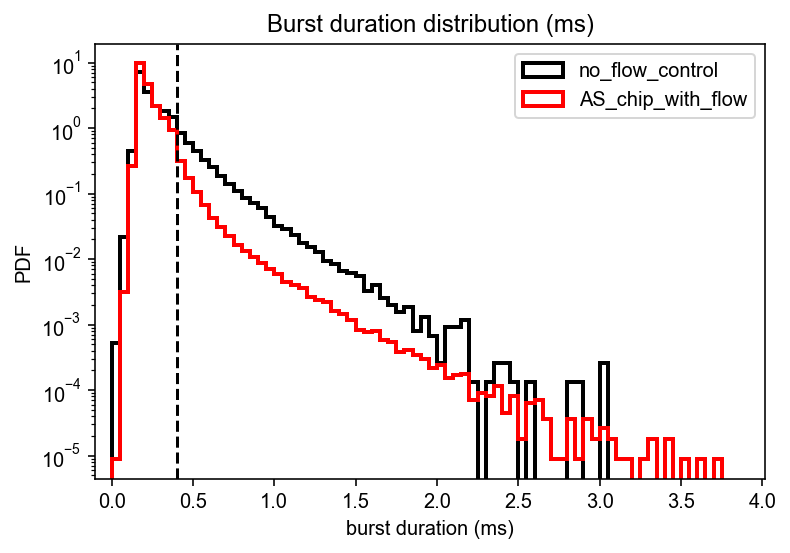

In [24]:
width_th = 0.4
column = 'width_ms'
binwidth = 0.05
hist_kws = dict(histtype='step', lw=2)

plt.figure()
width0 = bursts_all.loc[bursts_all.sample_description == sample_description0, column]
width1 = bursts_all.loc[bursts_all.sample_description == sample_description1, column]
bin0 = np.arange(-1, width0.max(), binwidth)
bin1 = np.arange(-1, width1.max(), binwidth)

plt.hist(width0, density=True, stacked=True, label='no_flow_control', color='k', bins=bin0, **hist_kws)
plt.hist(width1, density=True, stacked=True, label='AS_chip_with_flow', color='r', bins=bin1, **hist_kws)

plt.axvline(width_th, color='k', ls='--')
plt.legend(loc='upper right')
plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('burst duration (ms)')
plt.title(f'Burst duration distribution (ms)');
plt.xlim(-.1, width0.quantile(0.99999) + 1)
plt.savefig('burst_duration_PDF_nt.png', dpi=1200);

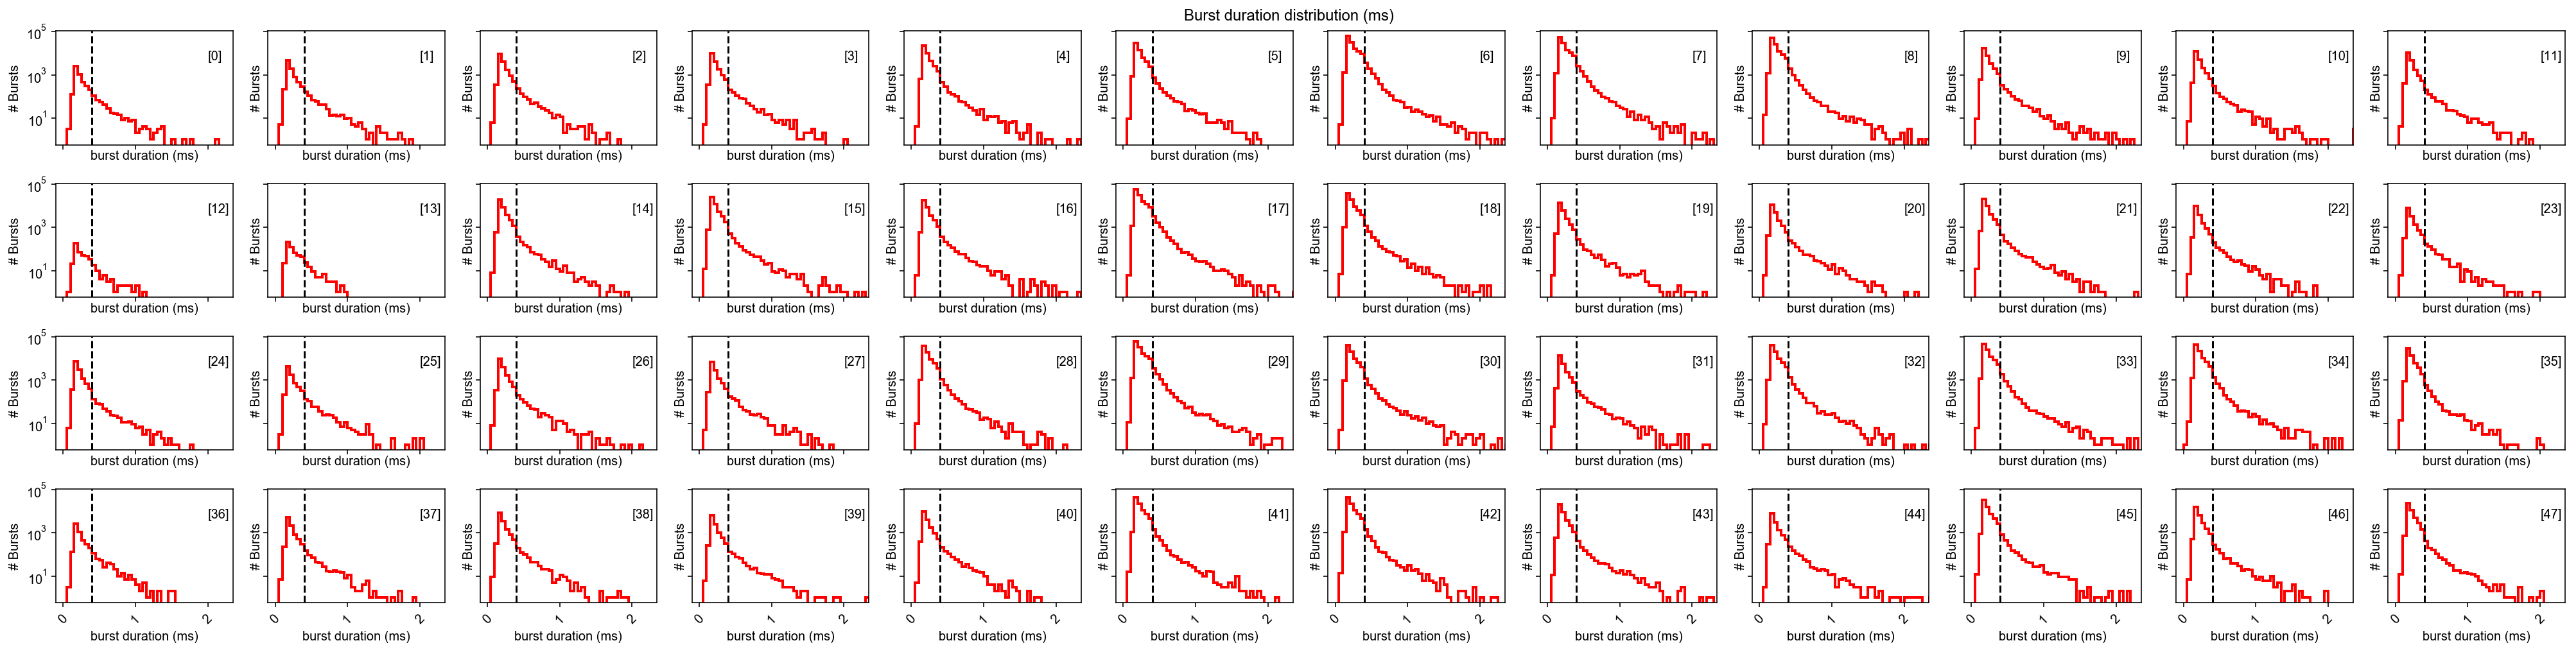

In [25]:
nrows = 4
ncols = 12
figsize = (1.5 * ncols + 10, 1.5 * nrows + 1)
xrotation = 45

binwidth = 0.05
width_th = 0.4
column = 'width_ms'
hist_kws = dict(histtype='step', lw=2)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=figsize)
axes_list = [item for sublist in axes for item in sublist] 

for spot, group in bursts_all.groupby('spot'):
    ax = axes_list[spot]
    width0 = group.loc[group.sample_description == sample_description0, column]
    width1 = group.loc[group.sample_description == sample_description1, column]
    #bins0 = np.arange(-1, width0.max(), binwidth)
    bins = np.arange(-1, width1.max(), binwidth)
    #ax.hist(width0, bins, color='r', **hist_kws)
    ax.hist(width1, bins, color='r', **hist_kws)
    ax.set_yscale('log')
    ax.axvline(width_th, color='k', ls='--')
    ax.set_xlim(-.1, width1.quantile(0.99999))
    ax.set_xlabel('burst duration (ms)')
    ax.set_ylabel('# Bursts')
    ax.text(2, 5e3, f'[{spot}]')
    #ax.legend(loc='upper right', prop={'size': 8})
    plt.setp(ax.get_xticklabels(), rotation=xrotation)
fig.suptitle(f'Burst duration distribution (ms)', x=0.5,y=1.0)
plt.tight_layout()
plt.savefig('burst_duration_distribution_48_spots_nt_flow_only.png', dpi=1200);

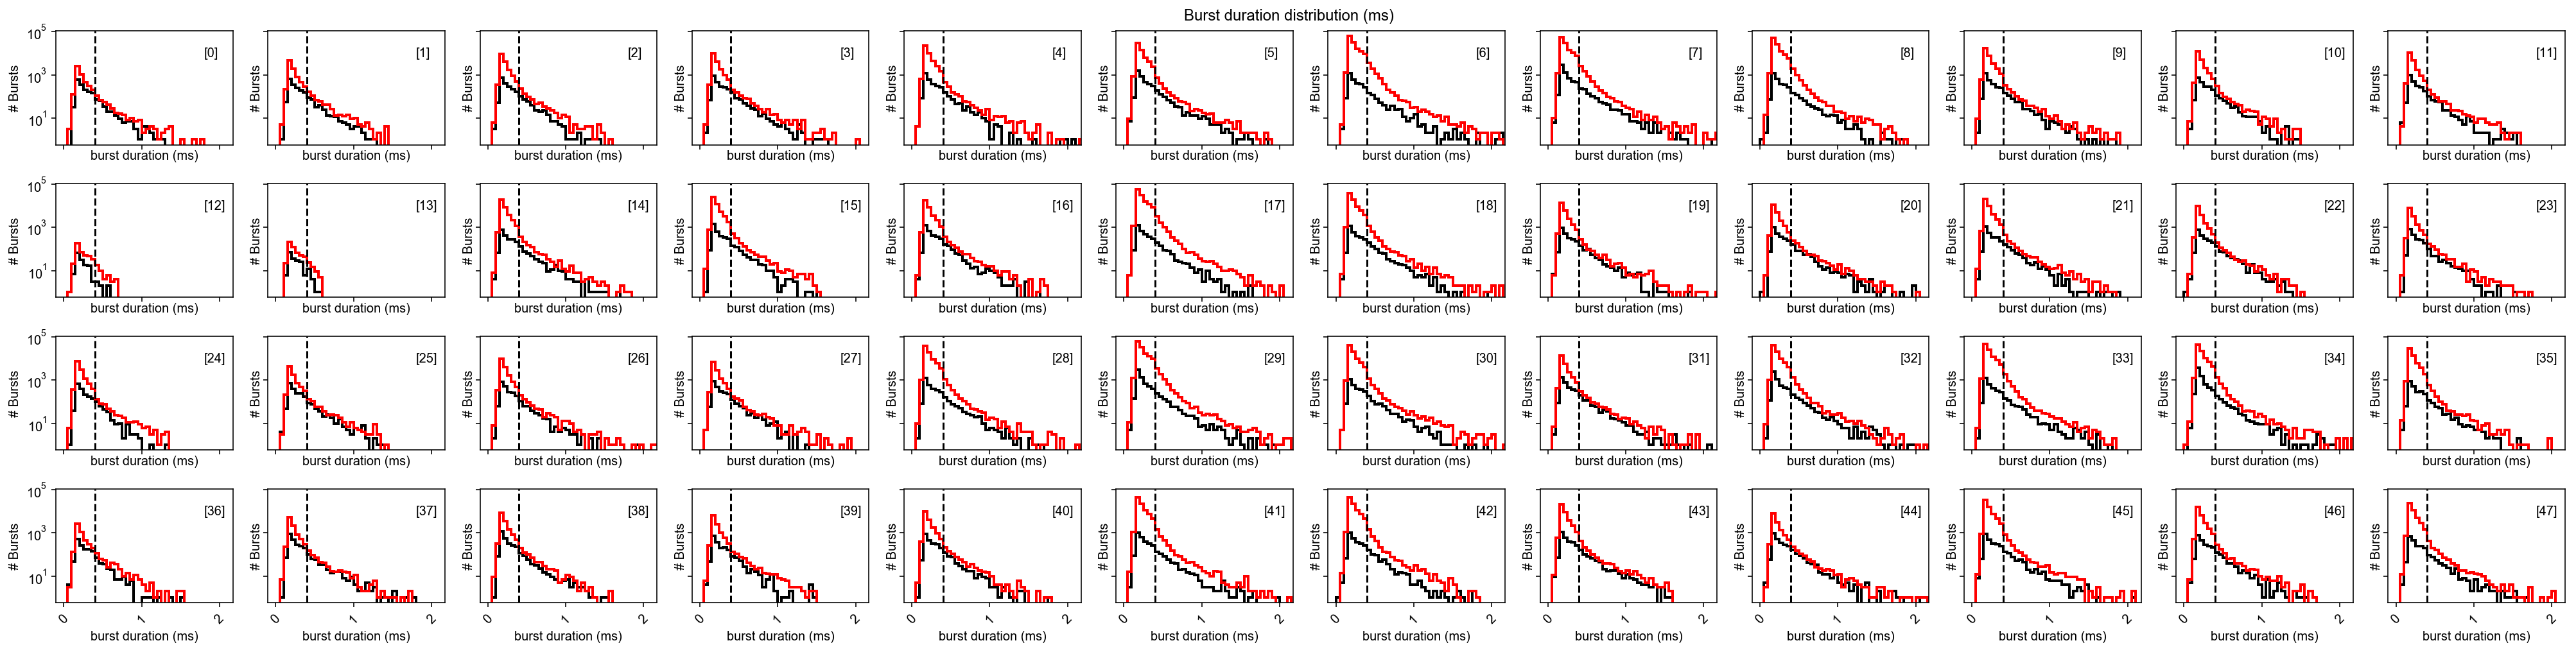

In [26]:
nrows = 4
ncols = 12
figsize = (1.5 * ncols + 10, 1.5 * nrows + 1)
xrotation = 45

binwidth = 0.05
width_th = 0.4
column = 'width_ms'
hist_kws = dict(histtype='step', lw=2)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=figsize)
axes_list = [item for sublist in axes for item in sublist] 

for spot, group in bursts_all.groupby('spot'):
    ax = axes_list[spot]
    width0 = group.loc[group.sample_description == sample_description0, column]
    width1 = group.loc[group.sample_description == sample_description1, column]
    bins = np.arange(-1, width0.max(), binwidth)
    #bins = np.arange(-1, width1.max(), binwidth)
    ax.hist(width0, bins, color='k', **hist_kws)
    ax.hist(width1, bins, color='r', **hist_kws)
    ax.set_yscale('log')
    ax.axvline(width_th, color='k', ls='--')
    ax.set_xlim(-.1, width0.quantile(0.99999))
    ax.set_xlabel('burst duration (ms)')
    ax.set_ylabel('# Bursts')
    ax.text(1.8, 7e3, f'[{spot}]')
    #ax.legend(loc='upper right', prop={'size': 8})
    plt.setp(ax.get_xticklabels(), rotation=xrotation)
fig.suptitle(f'Burst duration distribution (ms)', x=0.5,y=1.0)
plt.tight_layout()
plt.savefig('burst_duration_distribution_48_spots_nt.png', dpi=1200);

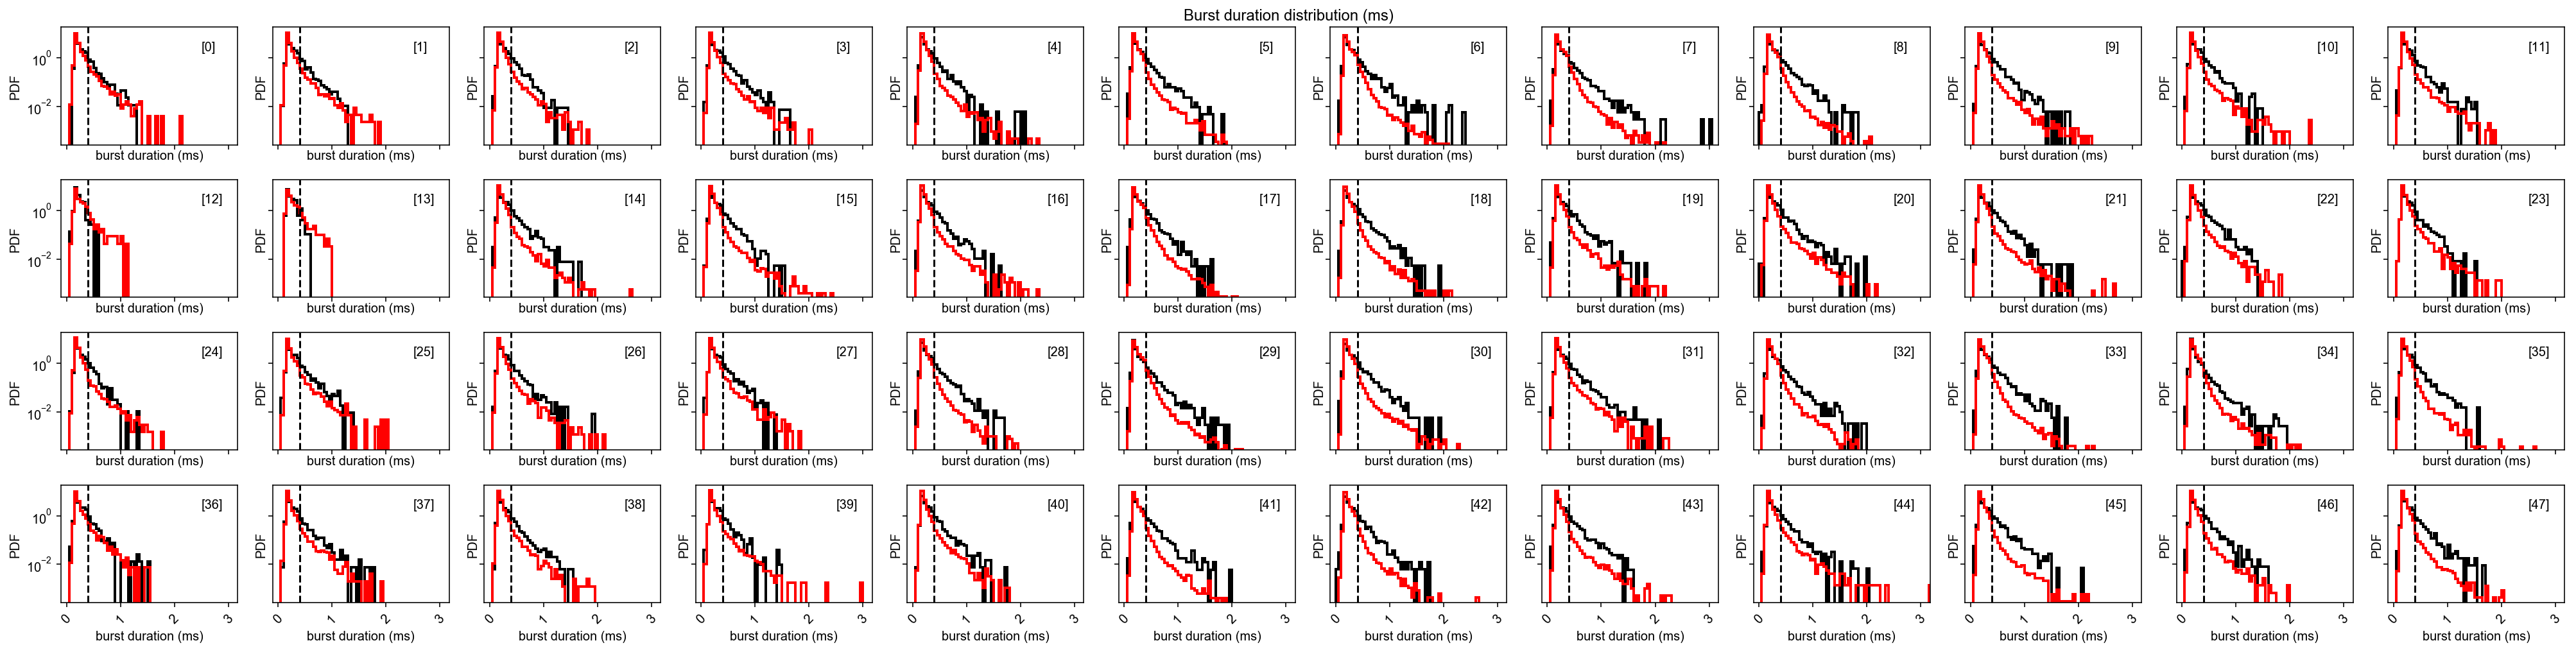

In [27]:
nrows = 4
ncols = 12
figsize = (1.5 * ncols + 10, 1.5 * nrows + 1)
xrotation = 45

binwidth = 0.05
width_th = 0.4
column = 'width_ms'
hist_kws = dict(histtype='step', lw=2)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=figsize)
axes_list = [item for sublist in axes for item in sublist] 

for spot, group in bursts_all.groupby('spot'):
    ax = axes_list[spot]
    width0 = group.loc[group.sample_description == sample_description0, column]
    width1 = group.loc[group.sample_description == sample_description1, column]
    bins0 = np.arange(-1, width0.max(), binwidth)
    bins1 = np.arange(-1, width1.max(), binwidth)
    ax.hist(width0, bins0, density=True, stacked=True, color='k', **hist_kws)
    ax.hist(width1, bins1, density=True, stacked=True, color='r', **hist_kws)
    ax.set_yscale('log')
    ax.axvline(width_th, color='k', ls='--')
    ax.set_xlim(-.1, width0.quantile(0.99999) + 1)
    ax.set_xlabel('burst duration (ms)')
    ax.set_ylabel('PDF')
    ax.text(2.5, 2e0, f'[{spot}]')
    #ax.legend(loc='upper right', prop={'size': 8})
    plt.setp(ax.get_xticklabels(), rotation=xrotation)
fig.suptitle(f'Burst duration distribution (ms)', x=0.5,y=1.0)
plt.tight_layout()
plt.savefig('burst_duration_PDF_48_spots_nt.png', dpi=1200);

# Peak photon rate distribution

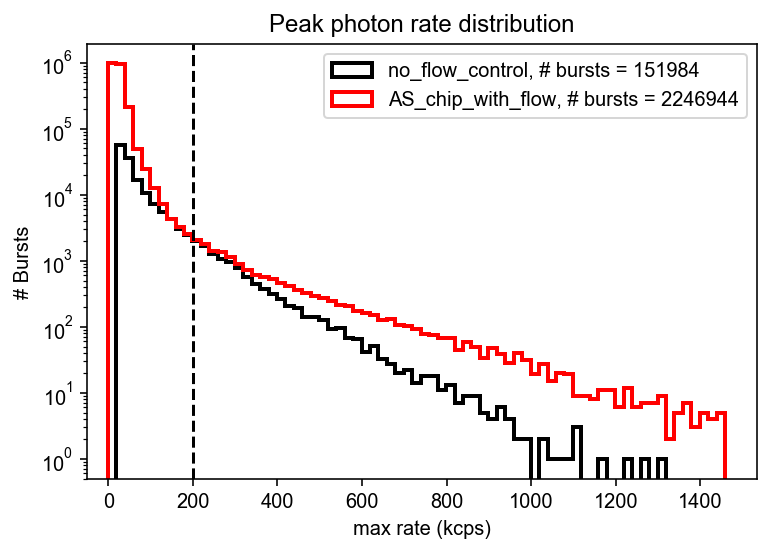

In [28]:
rate_th = 200
column = 'max_rate'
binwidth = 20
hist_kws = dict(histtype='step', lw=2)

plt.figure()
rate0 = bursts_all.loc[bursts_all.sample_description == sample_description0, column]*1e-3
rate1 = bursts_all.loc[bursts_all.sample_description == sample_description1, column]*1e-3
bins = np.arange(-1, rate0.max(), binwidth)
#bin1 = np.arange(-1, rate1.max(), binwidth)

plt.hist(rate0, label=f'{sample_description0}, # bursts = {num_bursts0}', color='k', bins=bins, **hist_kws)
plt.hist(rate1, label=f'{sample_description1}, # bursts = {num_bursts1}', color='r', bins=bins, **hist_kws)

plt.axvline(rate_th, color='k', ls='--')

plt.legend(loc='upper right')
plt.yscale('log')
plt.ylabel('# Bursts')
plt.xlabel('max rate (kcps)')
plt.title(f'Peak photon rate distribution');
plt.xlim(-50, rate0.quantile(0.99999) + 250)
plt.savefig('peak_photon_rate_distribution_nt.png', dpi=1200);

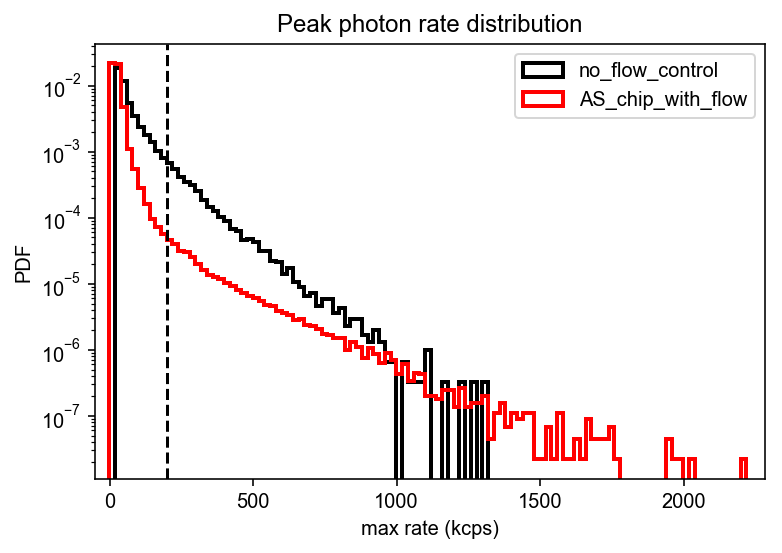

In [29]:
rate_th = 200
column = 'max_rate'
binwidth = 20
hist_kws = dict(histtype='step', lw=2)

plt.figure()
rate0 = bursts_all.loc[bursts_all.sample_description == sample_description0, column]*1e-3
rate1 = bursts_all.loc[bursts_all.sample_description == sample_description1, column]*1e-3
bin0 = np.arange(-1, rate0.max(), binwidth)
bin1 = np.arange(-1, rate1.max(), binwidth)

plt.hist(rate0, density=True, stacked=True, label='no_flow_control', color='k', bins=bin0, **hist_kws)
plt.hist(rate1, density=True, stacked=True, label='AS_chip_with_flow', color='r', bins=bin1, **hist_kws)

plt.axvline(rate_th, color='k', ls='--')

plt.legend(loc='upper right')
plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('max rate (kcps)')
plt.title(f'Peak photon rate distribution');
plt.xlim(-50, rate0.quantile(0.99999) + 1000)
plt.savefig('peak_photon_rate_PDF_nt.png', dpi=1200);

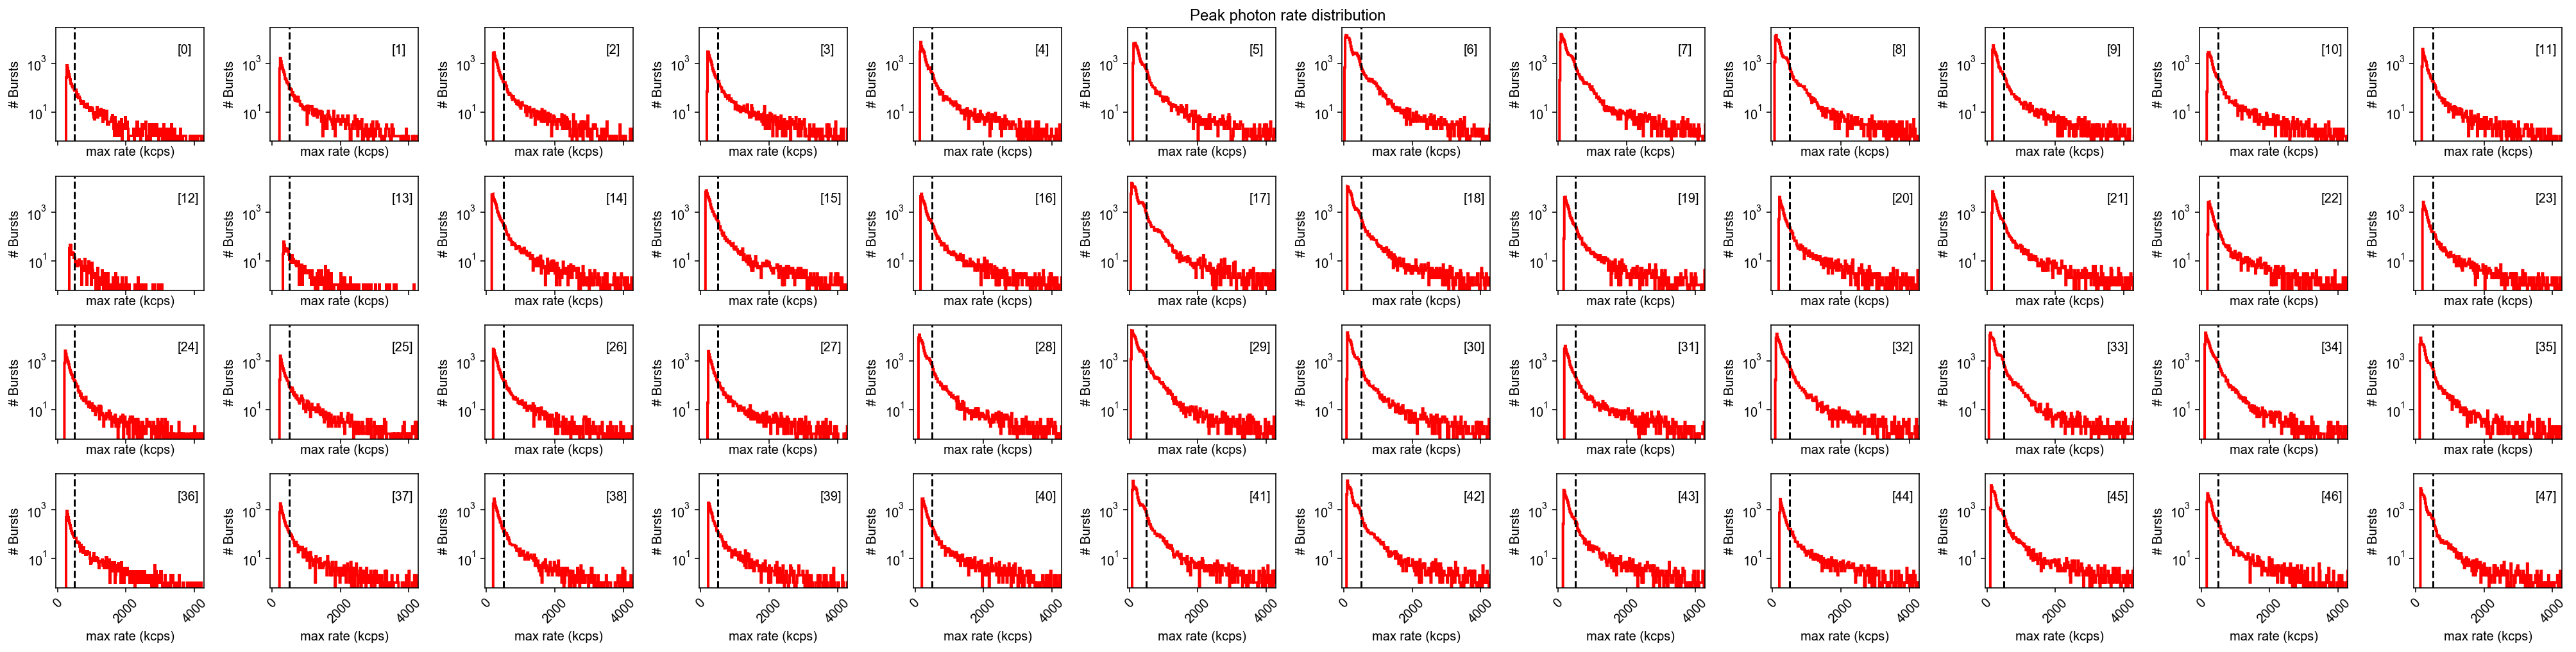

In [30]:
nrows = 4
ncols = 12
figsize = (1.5 * ncols + 10, 1.5 * nrows + 1)
xrotation = 45

rate_th = 500
column = 'max_rate'
binwidth = 20
hist_kws = dict(histtype='step', lw=2)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=figsize)
axes_list = [item for sublist in axes for item in sublist] 

for spot, group in bursts_all.groupby('spot'):
    ax = axes_list[spot]
    #rate0 = group.loc[group.sample_description == sample_description0, column]*10e-3
    rate1 = group.loc[group.sample_description == sample_description1, column]*10e-3
    #bins0 = np.arange(-1, rate0.max(), binwidth)
    bins = np.arange(-1, rate1.max(), binwidth)
    #ax.hist(rate0, bins, color='k', **hist_kws)
    ax.hist(rate1, bins, color='r', **hist_kws)
    ax.set_yscale('log')
    ax.axvline(rate_th, color='k', ls='--')
    ax.set_xlim(-50, rate0.quantile(0.99999) + 3e3)
    ax.set_xlabel('max rate (kcps)')
    ax.set_ylabel('# Bursts')
    ax.text(3.5e3, 2.5e3, f'[{spot}]')
    #ax.xaxis.set_tick_params(labelbottom=True, rotation=xrotation)
    #plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")
    ax.yaxis.set_tick_params(which='both', labelbottom=True)
    #ax.legend(loc='upper right', prop={'size': 8})
    plt.setp(ax.get_xticklabels(), rotation=xrotation)
    #plt.setp(ax.get_yticklabels())
fig.suptitle(f'Peak photon rate distribution', x=0.5,y=1.0)
plt.tight_layout()
plt.savefig('peak_photon_rate_distribution_48_spots_nt_flow_only.png', dpi=1200);

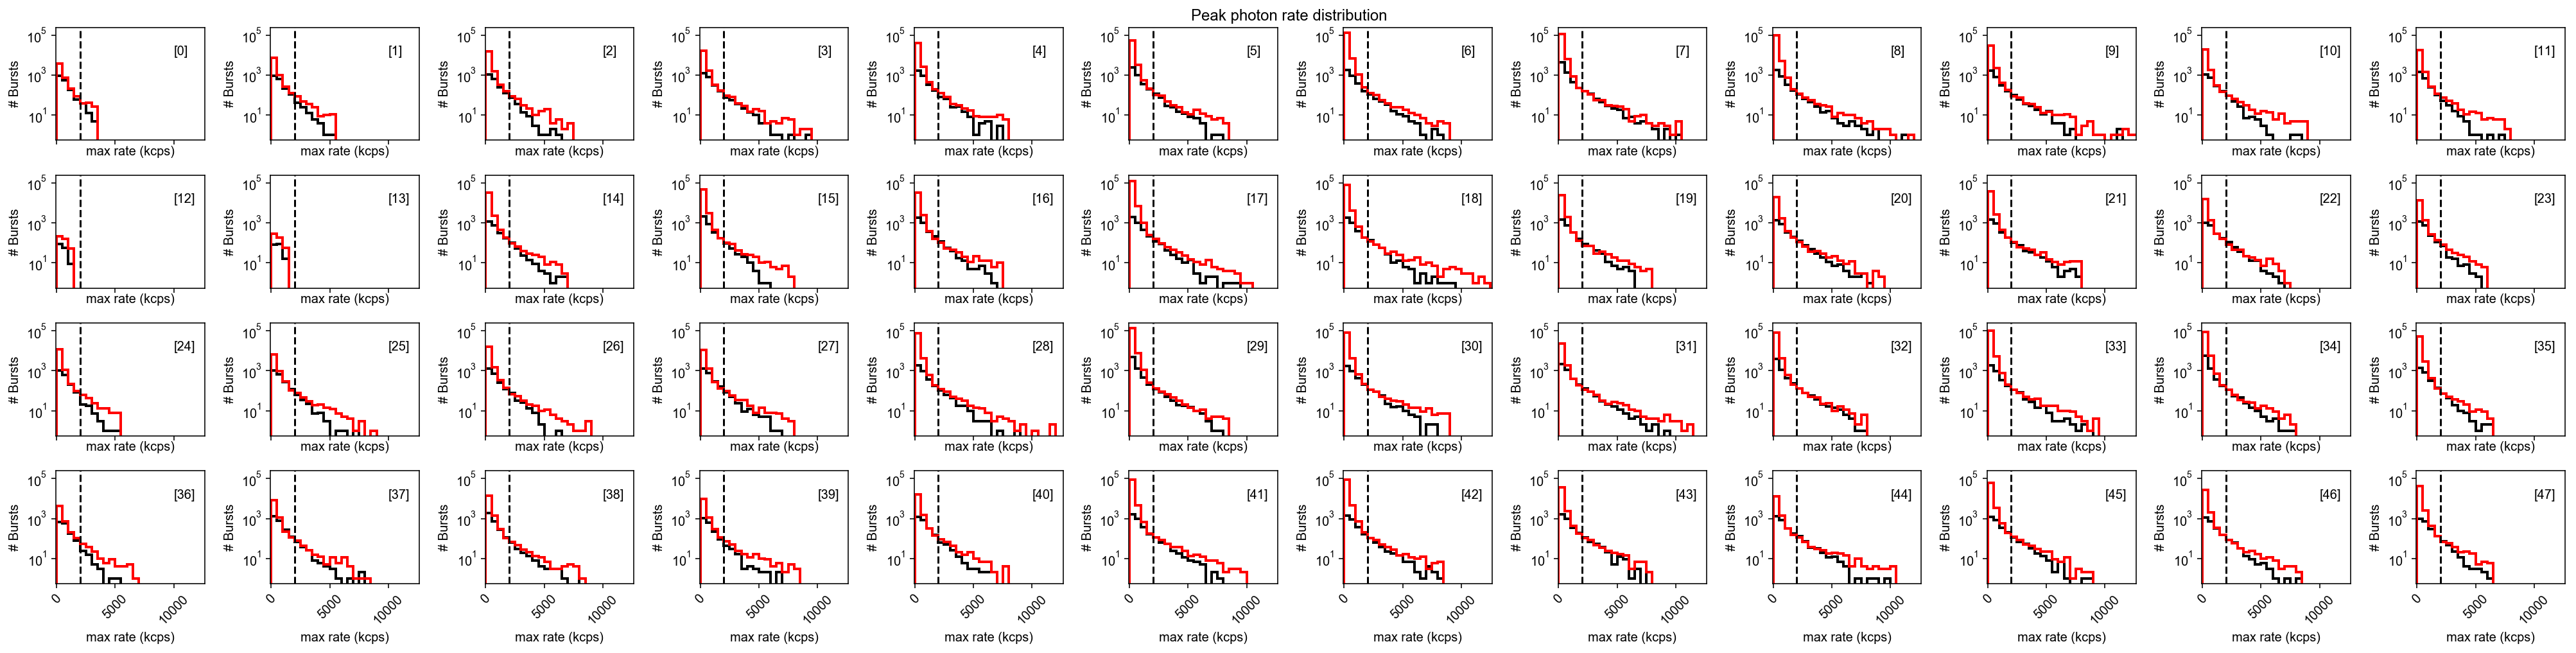

In [31]:
nrows = 4
ncols = 12
figsize = (1.5 * ncols + 10, 1.5 * nrows + 1)
xrotation = 45

rate_th = 2e3
column = 'max_rate'
binwidth = 500
hist_kws = dict(histtype='step', lw=2)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=figsize)
axes_list = [item for sublist in axes for item in sublist] 

for spot, group in bursts_all.groupby('spot'):
    ax = axes_list[spot]
    rate0 = group.loc[group.sample_description == sample_description0, column]*10e-3
    rate1 = group.loc[group.sample_description == sample_description1, column]*10e-3
    bins = np.arange(-1, rate0.max(), binwidth)
    #bins1 = np.arange(-1, rate1.max(), binwidth)
    ax.hist(rate0, bins, color='k', **hist_kws)
    ax.hist(rate1, bins, color='r', **hist_kws)
    ax.set_yscale('log')
    ax.axvline(rate_th, color='k', ls='--')
    ax.set_xlim(-50, rate0.quantile(0.99999) + 6e3)
    ax.set_xlabel('max rate (kcps)')
    ax.set_ylabel('# Bursts')
    ax.text(1e4, 1e4, f'[{spot}]')
    #ax.xaxis.set_tick_params(labelbottom=True, rotation=xrotation)
    #plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")
    ax.yaxis.set_tick_params(which='both', labelbottom=True)
    #ax.legend(loc='upper right', prop={'size': 8})
    plt.setp(ax.get_xticklabels(), rotation=xrotation)
    #plt.setp(ax.get_yticklabels())
fig.suptitle(f'Peak photon rate distribution', x=0.5,y=1.0)
plt.tight_layout()
plt.savefig('peak_photon_rate_distribution_48_spots_nt.png', dpi=1200);

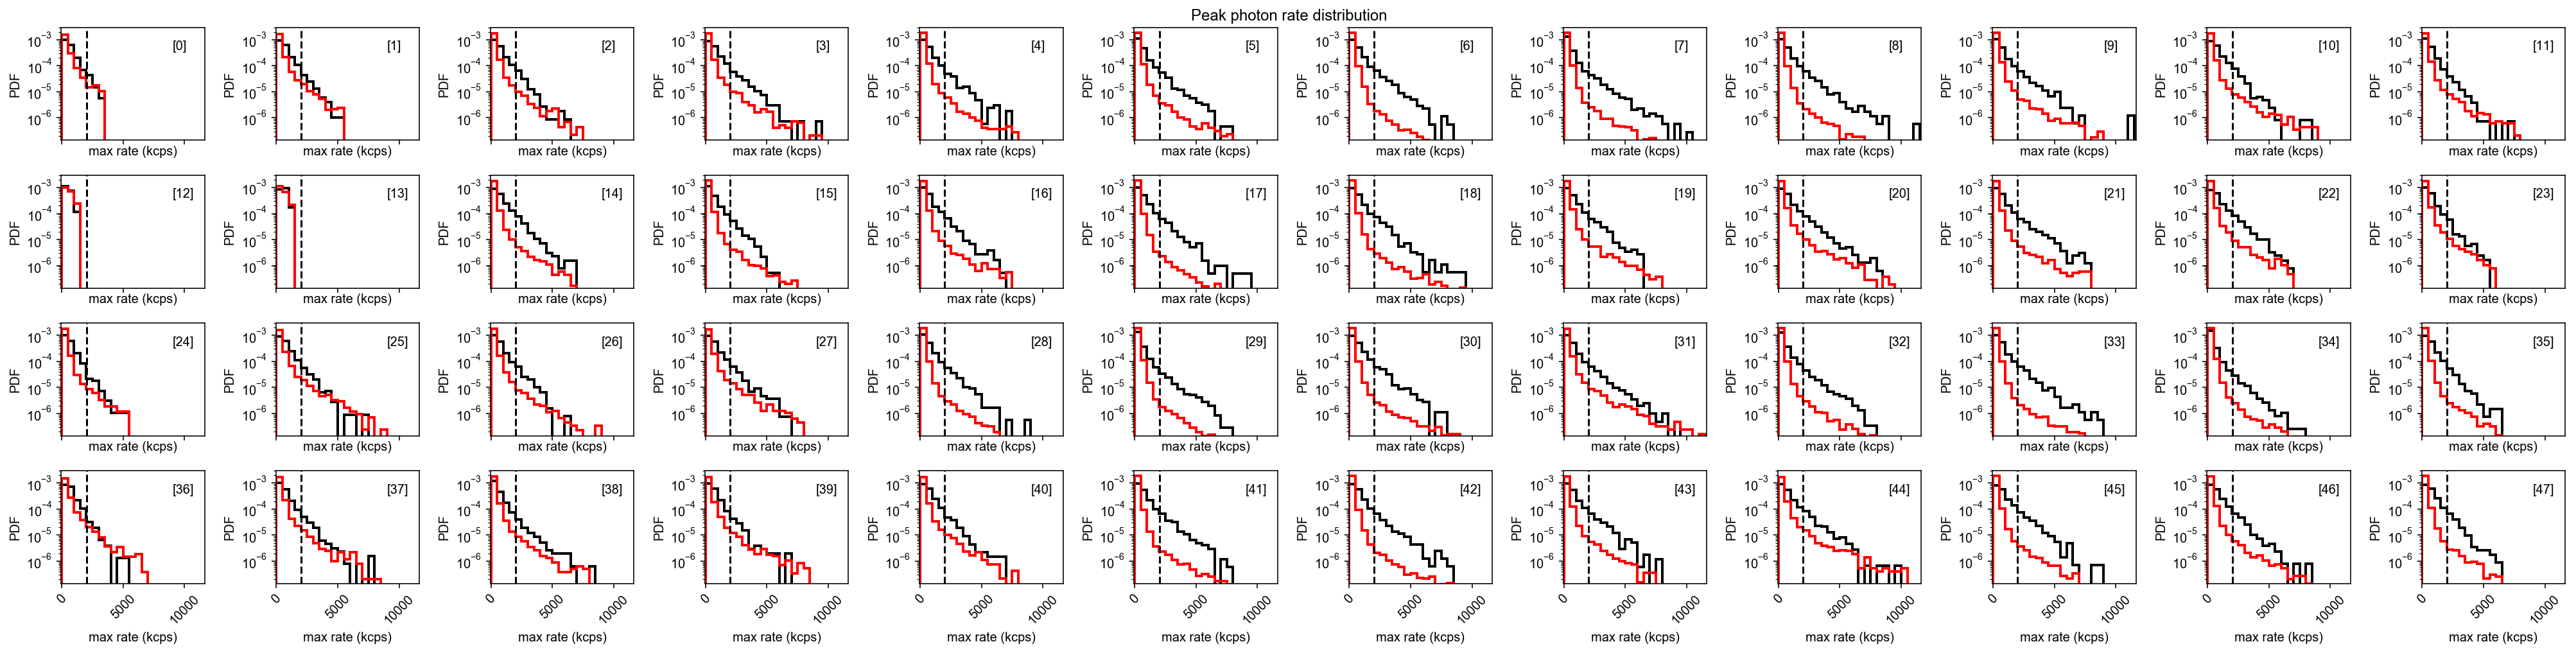

In [32]:
nrows = 4
ncols = 12
figsize = (1.5 * ncols + 10, 1.5 * nrows + 1)
xrotation = 45

rate_th = 2e3
column = 'max_rate'
binwidth = 500
hist_kws = dict(histtype='step', lw=2)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=figsize)
axes_list = [item for sublist in axes for item in sublist] 

for spot, group in bursts_all.groupby('spot'):
    ax = axes_list[spot]
    rate0 = group.loc[group.sample_description == sample_description0, column]*10e-3
    rate1 = group.loc[group.sample_description == sample_description1, column]*10e-3
    bins = np.arange(-1, rate0.max(), binwidth)
    #bins1 = np.arange(-1, rate1.max(), binwidth)
    ax.hist(rate0, bins, density=True, stacked=True, color='k', **hist_kws)
    ax.hist(rate1, bins, density=True, stacked=True, color='r', **hist_kws)
    ax.set_yscale('log')
    ax.axvline(rate_th, color='k', ls='--')
    ax.set_xlim(-50, rate0.quantile(0.99999) + 5e3)
    ax.set_xlabel('max rate (kcps)')
    ax.set_ylabel('PDF')
    ax.text(9e3, 4e-4, f'[{spot}]')
    #ax.xaxis.set_tick_params(labelbottom=True, rotation=xrotation)
    #plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")
    ax.yaxis.set_tick_params(which='both', labelbottom=True)
    #ax.legend(loc='upper right', prop={'size': 8})
    plt.setp(ax.get_xticklabels(), rotation=xrotation)
    #plt.setp(ax.get_yticklabels())
fig.suptitle(f'Peak photon rate distribution', x=0.5,y=1.0)
plt.tight_layout()
plt.savefig('peak_photon_rate_PDF_48_spots_nt.png', dpi=1200);